In [1]:
!kaggle competitions download -c cassava-leaf-disease-classification

100%|█████████████████████████████████████▉| 5.76G/5.76G [25:36<00:00, 4.29MB/s]
100%|██████████████████████████████████████| 5.76G/5.76G [25:36<00:00, 4.03MB/s]


In [1]:
!unzip -q cassava-leaf-disease-classification.zip -d cassava-leaf-disease-classification

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
logical = tf.config.list_logical_devices('GPU')
print(len(gpus), 'Physical GPUs', len(logical), 'Logical GPUs')

tf.random.set_seed(666)

1 Physical GPUs 1 Logical GPUs


In [2]:
samples_df = pd.read_csv('./cassava-leaf-disease-classification/train.csv')
samples_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
TRAIN_FOLDER = './cassava-leaf-disease-classification/train_images/'
samples_df['filepath'] = TRAIN_FOLDER + samples_df['image_id']
samples_df.head()

,image_id,label,filepath
0,1000015157.jpg,0,./cassava-leaf-disease-classification/train_im...
1,1000201771.jpg,3,./cassava-leaf-disease-classification/train_im...
2,100042118.jpg,1,./cassava-leaf-disease-classification/train_im...
3,1000723321.jpg,1,./cassava-leaf-disease-classification/train_im...
4,1000812911.jpg,3,./cassava-leaf-disease-classification/train_im...


In [4]:
CLASSES = sorted(samples_df.label.unique())
print(CLASSES)

[0, 1, 2, 3, 4]


In [5]:
training_percentage = 0.8
samples_df = samples_df.sample(frac=1)
training_size = int(len(samples_df) * training_percentage)
validation_size = len(samples_df) - training_size
training_df = samples_df[:training_size]
validation_df = samples_df[training_size:]

print('training size: ', training_size)
print('vlaidation size: ', validation_size)

training_df.head()

training size:  17117
vlaidation size:  4280


,image_id,label,filepath
12303,3204522737.jpg,1,./cassava-leaf-disease-classification/train_im...
13410,3399115002.jpg,3,./cassava-leaf-disease-classification/train_im...
11891,3125296469.jpg,0,./cassava-leaf-disease-classification/train_im...
1327,1233286734.jpg,3,./cassava-leaf-disease-classification/train_im...
18112,4261199097.jpg,1,./cassava-leaf-disease-classification/train_im...


In [6]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))


def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label


AUTOTUNE = tf.data.experimental.AUTOTUNE

training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
print('training data: ', training_data)
print('validation data: ', validation_data)

training data:  <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
validation data:  <ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [7]:
BATCH_SIZE = 8

training_ds = training_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print(training_ds)
print(validation_ds)

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.uint8, tf.int64)>


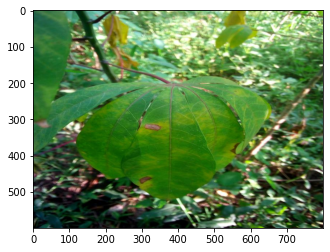

In [8]:
for batch in training_data:
  image, label = batch
  plt.imshow(image)
  plt.show()
  break

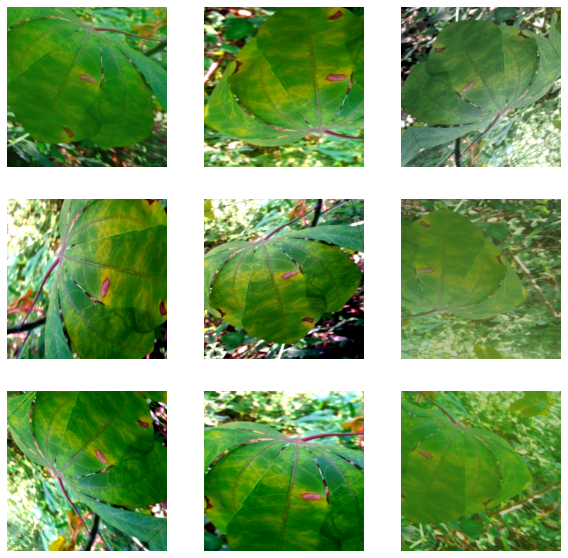

In [11]:
IMAGE_SIZE = 512

class RandomHueSaturation(layers.experimental.preprocessing.PreprocessingLayer):
  def __init__(self, hue_limit, saturation_limit, seed=None, name=None, **kwargs):
    self.hue_limit = hue_limit
    self.saturation_limit = saturation_limit
    self.seed = seed
    super(RandomHueSaturation, self).__init__(name=name, **kwargs)

  def call(self, inputs, training=True):
    if training is None:
      training = K.learning_phase()
    training = tf.cast(training, tf.bool)

    def random_contrasted_inputs():
      img = tf.image.random_hue(inputs, self.hue_limit, seed=self.seed)
      img = tf.image.random_saturation(img, self.saturation_limit[0], self.saturation_limit[1],
                                       seed=self.seed)
      return img

    output = tf.cond(training, random_contrasted_inputs, lambda: inputs)
    output.set_shape(inputs.shape)
    return output

  def compute_output_shape(self, input_shape):
    return input_shape

  def get_config(self):
    config = {
        'hue_limit': self.hue_limit,
        'saturation_limit': self.saturation_limit,
    }
    base_config = super(RandomHueSaturation, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))
  
  
# class RandomCutout(layers.experimental.preprocessing.PreprocessingLayer):
#   def __init__(self, mask_size, seed=None, name=None, **kwargs):
#     self.hue_limit = hue_limit
#     self.saturation_limit = saturation_limit
#     self.seed = seed
#     super(RandomCutout, self).__init__(name=name, **kwargs)


augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.6),
  layers.experimental.preprocessing.RandomZoom((-0.3, .0)),
  RandomHueSaturation(0.03, (0.5, 2)),
  layers.experimental.preprocessing.RandomContrast((0.5, 0.5)),
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
])

sample_image = tf.expand_dims(np.array(image), 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = augmentation(sample_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype(np.uint8))
  plt.axis("off")
plt.show()

In [12]:
EPOCHS = 10
DECAY_STEPS = int(round(len(samples_df) / BATCH_SIZE)) * EPOCHS

def build_model():
  model = keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    augmentation,
    keras.applications.EfficientNetB0(weights='imagenet', include_top=False),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(CLASSES), activation="softmax"),
  ])
  lr = keras.experimental.CosineDecay(initial_learning_rate=1e-4, decay_steps=DECAY_STEPS, alpha=0.3)
  model.compile(optimizer=optimizers.Adam(lr),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model


model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


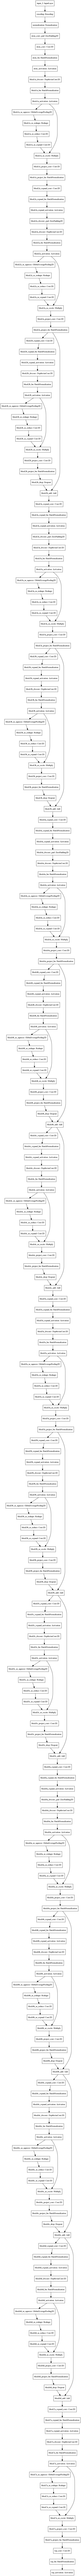

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model.get_layer('efficientnetb0'), to_file='conv_base.png')

In [14]:
def process_image_data(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = model.get_layer('efficientnetb0').get_layer('rescaling')(image)
  return image

image_data = tf.data.Dataset.from_tensor_slices((training_df.filepath.values))
image_data = image_data.map(process_image_data, num_parallel_calls=AUTOTUNE)
image_data = image_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
model.get_layer('efficientnetb0').get_layer('normalization').adapt(image_data)

In [15]:
def schedule(epoch, lr):
  if epoch in [10, 20]:
    return lr / 10.0
  return lr


save_point = callbacks.ModelCheckpoint(filepath='leaf_best_model_0_2.h5', monitor='val_accuracy', save_best_only=True, verbose=True)
scheduler = callbacks.LearningRateScheduler(schedule, verbose=True)

train_history = model.fit(training_ds,
                          epochs=EPOCHS,
                          validation_data=validation_ds,
                          callbacks=[save_point])

Epoch 1/30
2140/2140 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7771
Epoch 00001: val_accuracy improved from -inf to 0.84860, saving model to leaf_best_model_0_2.h5
2140/2140 [==============================] - 566s 264ms/step - loss: 0.6239 - accuracy: 0.7771 - val_loss: 0.4321 - val_accuracy: 0.8486
Epoch 2/30
2140/2140 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.8360
Epoch 00002: val_accuracy improved from 0.84860 to 0.86869, saving model to leaf_best_model_0_2.h5
2140/2140 [==============================] - 544s 254ms/step - loss: 0.4737 - accuracy: 0.8360 - val_loss: 0.4087 - val_accuracy: 0.8687
Epoch 3/30
2140/2140 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8563
Epoch 00003: val_accuracy did not improve from 0.86869
2140/2140 [==============================] - 542s 253ms/step - loss: 0.4262 - accuracy: 0.8563 - val_loss: 0.3991 - val_accuracy: 0.8685
Epoch 4/30
2140/2140 [=======================

Epoch 28/30
2140/2140 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9811
Epoch 00028: val_accuracy did not improve from 0.87640
2140/2140 [==============================] - 569s 266ms/step - loss: 0.0542 - accuracy: 0.9811 - val_loss: 1.0489 - val_accuracy: 0.8348
Epoch 29/30
2140/2140 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9808
Epoch 00029: val_accuracy did not improve from 0.87640
2140/2140 [==============================] - 542s 253ms/step - loss: 0.0549 - accuracy: 0.9808 - val_loss: 1.1382 - val_accuracy: 0.8355
Epoch 30/30
2140/2140 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9820
Epoch 00030: val_accuracy did not improve from 0.87640
2140/2140 [==============================] - 542s 253ms/step - loss: 0.0523 - accuracy: 0.9820 - val_loss: 1.0160 - val_accuracy: 0.8350


### Evaluation

In [18]:
test_df = pd.read_csv('./cassava-leaf-disease-classification/sample_submission.csv')
test_df.head()

,image_id,label
0,2216849948.jpg,4


In [26]:
from tqdm import tqdm
from PIL import Image

TEST_FOLDER = 'cassava-leaf-disease-classification/test_images'

def predict_test(sample_count=6):
  prediction = []
  for i in tqdm(range(len(test_df.values))):
    row = test_df.values[i]
    img_path = os.path.join(TEST_FOLDER, row[0])
    image = Image.open(img_path)
    image = np.expand_dims(np.array(image), 0)
    ans = model.predict(image)
    label = np.argmax(ans[0])
    prediction.append(label)
  return prediction

test_df['label'] = predict_test()

100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


In [27]:
test_df

,image_id,label
0,2216849948.jpg,4
